In [10]:
#Load and preprocess
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
    return images

In [11]:
#Load the images and preprocess them (resize, flatten, and normalize)
folder_path_class1 = r'C:\Users\786me\Desktop\FinalYearProject\ASDScanPath\Dataset\Orignal\Control'
folder_path_class2 = r'C:\Users\786me\Desktop\FinalYearProject\ASDScanPath\Dataset\Orignal\Patient'

# Load images from each class folder
images_class1 = load_images_from_folder(folder_path_class1)
images_class2 = load_images_from_folder(folder_path_class2)

# Assign labels to images (0 for class1, 1 for class2)
labels_class1 = [0] * len(images_class1)
labels_class2 = [1] * len(images_class2)

# Resize the images to a consistent size
resize_dim = (224, 224)
resized_images_class1 = [cv2.resize(img, resize_dim) for img in images_class1]
resized_images_class2 = [cv2.resize(img, resize_dim) for img in images_class2]

# Flatten and normalize the images into 1D arrays
flattened_images_class1 = [img.flatten() / 255.0 for img in resized_images_class1]
flattened_images_class2 = [img.flatten() / 255.0 for img in resized_images_class2]

# Combine the image data and labels
X = np.vstack((flattened_images_class1, flattened_images_class2))
y = np.hstack((labels_class1, labels_class2))


In [12]:
#Determine the optimal number of components for PCA
def optimal_n_components(data, explained_variance_threshold):
    pca = PCA()
    pca.fit(data)
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
    
    optimal_n = np.where(cumulative_explained_variance >= explained_variance_threshold)[0][0] + 1
    
    return optimal_n


explained_variance_threshold = 0.99
n_components = optimal_n_components(X, explained_variance_threshold)

print(f'Optimal number of components for {explained_variance_threshold*100}% explained variance: {n_components}')

Optimal number of components for 99.0% explained variance: 502


In [13]:
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

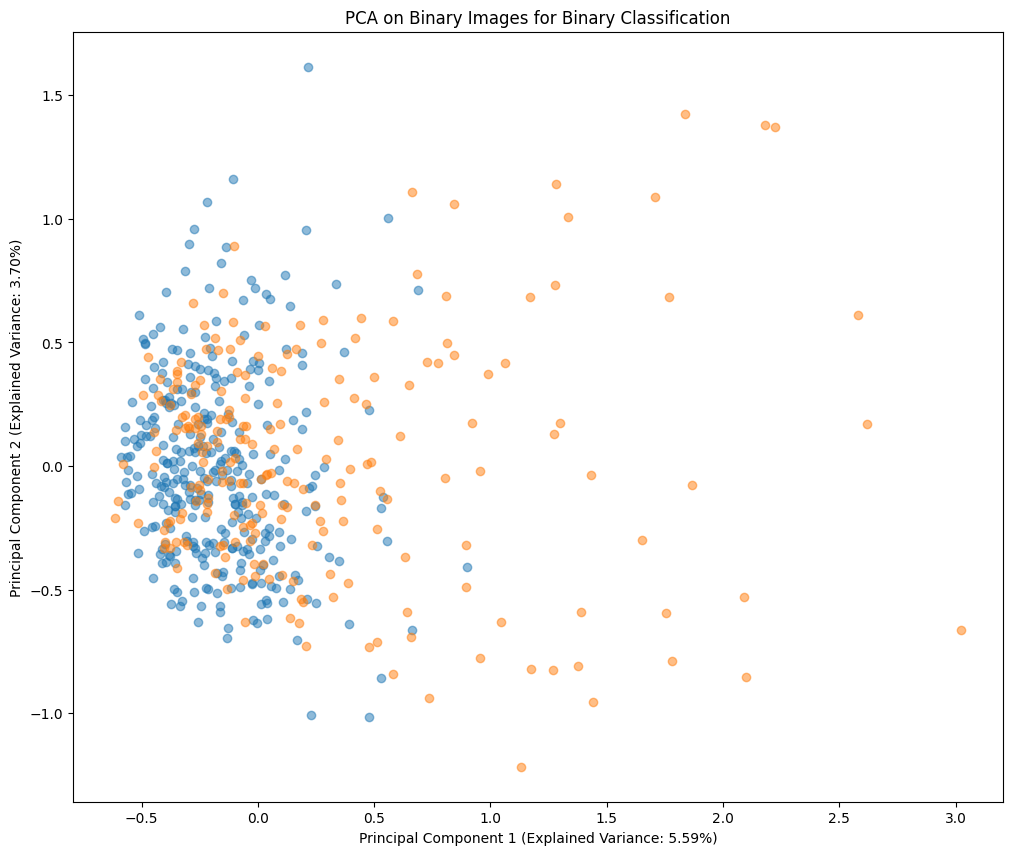

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
colors = ['tab:blue', 'tab:orange']
for i in range(len(X_pca)):
    plt.scatter(X_pca[i, 0], X_pca[i, 1], color=colors[y[i]], alpha=0.5)

plt.xlabel(f'Principal Component 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Principal Component 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})')
plt.title('PCA on Binary Images for Binary Classification')
plt.show()

In [15]:
#split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=42)


In [16]:
#Train an SVM classifier on the training data:
from sklearn.svm import SVC

# Initialize the SVM classifier
svm_classifier = SVC(kernel='linear', C=1)

# Train the classifier with the training data
svm_classifier.fit(X_train, y_train)


SVC(C=1, kernel='linear')

In [17]:
from sklearn.metrics import classification_report, accuracy_score
import pickle
# Make predictions on the test data
y_pred = svm_classifier.predict(X_test)

# Calculate the accuracy and print a classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

# Save the SVM model to a file
with open('svmPCA_ogDS.pkl', 'wb') as file:
    pickle.dump(svm_classifier, file)


Accuracy: 0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        88
           1       0.69      0.63      0.66        49

    accuracy                           0.77       137
   macro avg       0.75      0.74      0.74       137
weighted avg       0.76      0.77      0.76       137



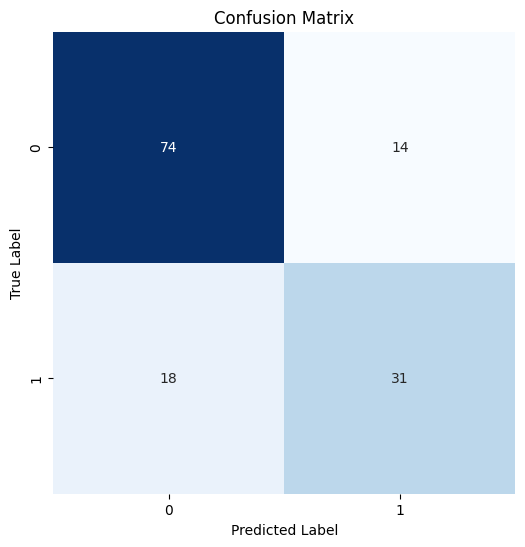

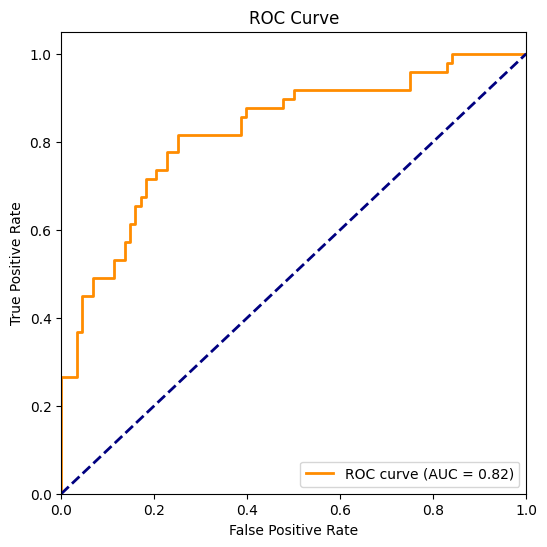

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import roc_curve, auc

# Get the decision scores for the test data
y_decision_scores = svm_classifier.decision_function(X_test)
# Calculate the false positive rate (FPR), true positive rate (TPR), and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_decision_scores)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()



In [19]:
## Decision Jungle
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier


C:\Users\786me\AppData\Roaming\Python\Python311\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [20]:
# Create the Decision Jungle model
dj_classifier = HistGradientBoostingClassifier(max_iter=100, max_depth=3, learning_rate=0.1, random_state=42)

# Train the model on the PCA-transformed training data
dj_classifier.fit(X_train, y_train)


HistGradientBoostingClassifier(max_depth=3, random_state=42)

In [21]:
# Make predictions on the test data
y_pred = dj_classifier.predict(X_test)

In [22]:
# Calculate the accuracy and print a classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Accuracy: 0.73
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.76      0.78        88
           1       0.61      0.67      0.64        49

    accuracy                           0.73       137
   macro avg       0.71      0.72      0.71       137
weighted avg       0.74      0.73      0.73       137



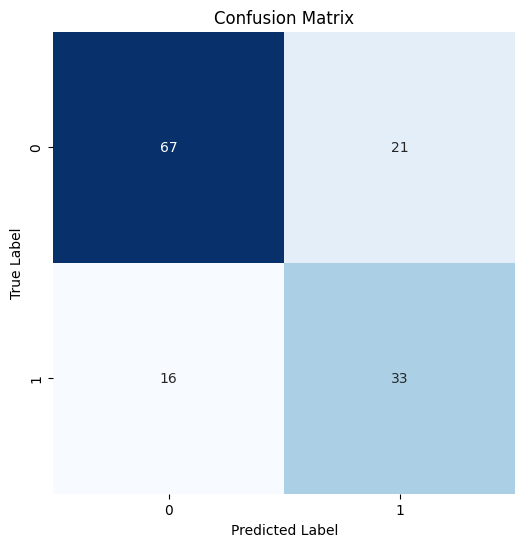

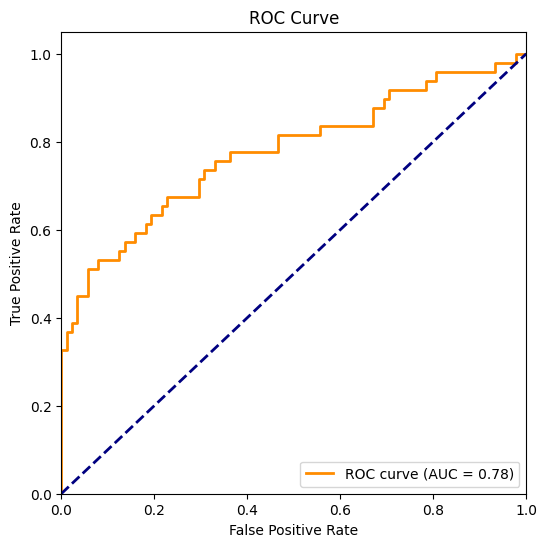

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import roc_curve, auc

# Get the decision scores for the test data
y_decision_scores = dj_classifier.decision_function(X_test)
# Calculate the false positive rate (FPR), true positive rate (TPR), and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_decision_scores)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
